In [39]:
# DS Modules
import numpy as np
import pandas as pd

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Helpers
import helpers
import wrangle

In [40]:
scores = {}

# Baseline modeling

In [41]:
from sklearn.linear_model import LinearRegression
from helpers.eval import BaselineModel

In [42]:
df = wrangle.wrangle_data('both')
train, test , validate = helpers.prep.train_test_validate_split(df)

In [43]:
train.type.value_counts(normalize=True), test.type.value_counts(normalize=True), validate.type.value_counts(normalize=True)

(white    0.74812
 red      0.25188
 Name: type, dtype: float64,
 white    0.733083
 red      0.266917
 Name: type, dtype: float64,
 white    0.745301
 red      0.254699
 Name: type, dtype: float64)

In [44]:
fs = (train, test, validate)
tx, sx, vx = (f['alcohol'] for f in fs)
ty, sy, vy = (f['quality'] for f in fs)

In [45]:
baseMean = BaselineModel()
baseMode = BaselineModel(method='mode')
baseLin = LinearRegression(positive=True, fit_intercept=True)

In [46]:
baseMean.fit(tx, ty)
baseMode.fit(tx, ty)
baseLin.fit(tx.to_numpy().reshape(-1, 1), ty)

LinearRegression(positive=True)

In [47]:
pred_mean = baseMean.predict(tx)
pred_mode = baseMode.predict(tx)
pred_lin = baseLin.predict(tx.to_numpy().reshape(-1,1))

In [48]:
scores['baseline_mean'] = helpers.eval.regression_metrics(ty, pred_mean)
scores['baseline_mode'] = helpers.eval.regression_metrics(ty, pred_mode)
scores['baseline_linear'] = helpers.eval.regression_metrics(ty, pred_lin)

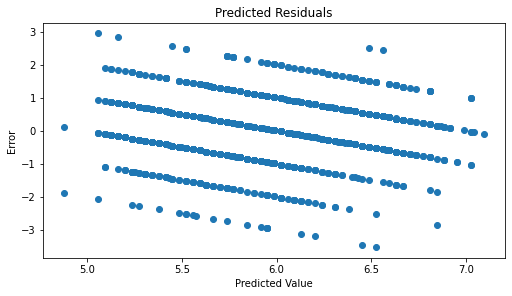

In [49]:
helpers.eval.plot_residuals(ty, pred_lin)

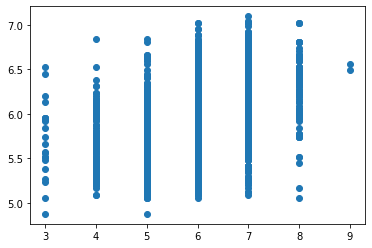

In [50]:
plt.scatter(train.quality, pred_lin)

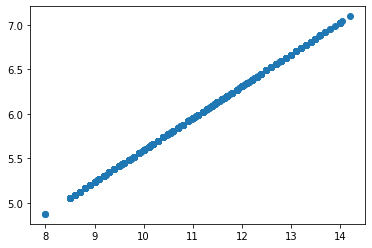

In [51]:
plt.scatter(train.alcohol, pred_lin)

In [52]:
helpers.eval.regression_metrics(train.quality, pred_lin)

{'max_error': 3.5231821602868756,
 'sum_squared_error': 1903.0271595627164,
 'mean_squared_error': 0.5961864534970917,
 'root_mean_squared_error': 0.7721311115976947,
 'mean_absolute_error': 0.6043167342461215,
 'r2_score': 0.2299842277536469}

In [53]:
helpers.eval.regression_metrics(train.quality, pred_mean)

{'max_error': 3.216478696741855,
 'sum_squared_error': 2471.413220551379,
 'mean_squared_error': 0.7742522620774996,
 'root_mean_squared_error': 0.8799160539946408,
 'mean_absolute_error': 0.6972708635624149,
 'r2_score': 0.0}

## Multinomial logistic regression

In [54]:
targets = ['quality']
features = ['alcohol','chlorides','volatile_acidity']

In [55]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced', multi_class='ovr')
# model = LogisticRegression(class_weight=None)


In [56]:
fs = (train, test, validate)
tx, sx, vx = (f[features] for f in fs)
tup = (tx, sx, vx)
ty, sy, vy = (f[targets] for f in fs)

In [57]:
scaler = helpers.prep.train_scaler(tx)

In [58]:
txs, sxs, vxs = (helpers.prep.scale_df(f, scaler) for f in tup)

In [59]:

model.fit(txs, ty)

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', multi_class='ovr')

In [60]:
tpred = model.predict(txs)

In [61]:
ty.shape, tpred.shape

((3192, 1), (3192,))

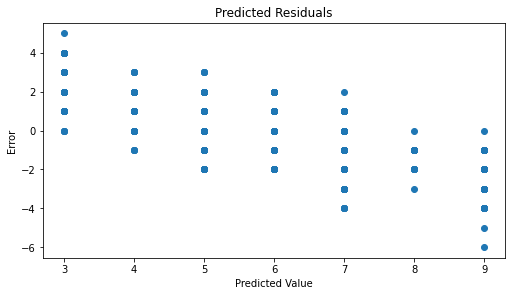

In [62]:
helpers.eval.plot_residuals(ty, tpred.reshape(-1,1))

In [63]:
scores['logistic_regression_balanced_with_ovr'] = helpers.eval.regression_metrics(ty, tpred.reshape(-1,1))

### Without OVR solver

In [64]:
alt_train = train[(train.quality > 7)| (train.quality < 5)]

In [65]:
fs = (train, test, validate)
tx, sx, vx = (f[features] for f in fs)
tup = (tx, sx, vx)
ty, sy, vy = (f[targets] for f in fs)
scaler = helpers.prep.train_scaler(tx)
txs, sxs, vxs = (helpers.prep.scale_df(f, scaler) for f in tup)

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


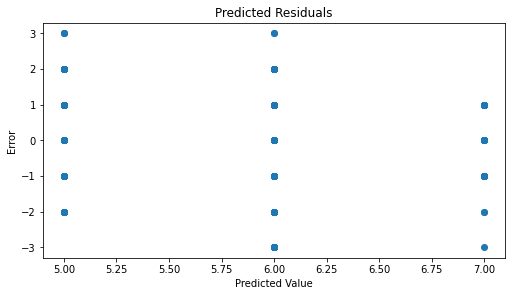

In [66]:
model = LogisticRegression()
model.fit(txs, ty)
tpred = model.predict(txs)
helpers.eval.plot_residuals(ty, tpred.reshape(-1,1))

In [67]:
scores['logistic_regression'] = helpers.eval.regression_metrics(ty, tpred.reshape(-1,1))

# Comparison

In [68]:
scores_df = pd.DataFrame.from_dict(scores, orient='index')

<AxesSubplot:xlabel='root_mean_squared_error'>

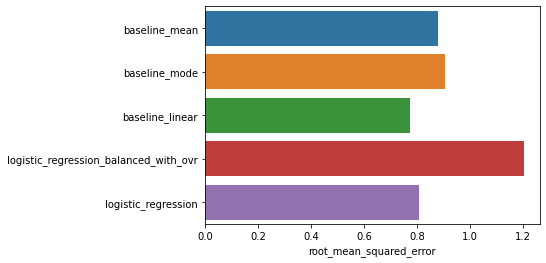

In [69]:
sns.barplot(data = scores_df, y=scores_df.index, x='root_mean_squared_error')

# Classification

In [70]:
train['is_good'] = train.quality > 6
train['is_bad'] = train.quality < 5

In [152]:
test['is_good'] = test.quality > 6
test['is_bad'] = test.quality < 5

In [153]:
validate['is_good'] = validate.quality > 6
validate['is_bad'] = validate.quality < 5

In [71]:
1- train.is_good.mean()

0.8148496240601504

In [110]:
import xgboost as xgb

model = xgb.XGBClassifier(max_depth=5)

In [111]:
to_drop = ['quality','is_good','is_bad', 'type']
tx = train.drop(columns=to_drop)
tx.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
434,10.4,0.41,0.55,3.2,0.076,22.0,54.0,0.99960,3.15,0.89,9.9
3936,6.5,0.28,0.35,9.8,0.067,61.0,180.0,0.99720,3.15,0.57,9.0
3914,7.7,0.42,0.38,8.1,0.061,49.0,144.0,0.99660,3.40,0.58,11.0
5272,5.4,0.30,0.30,1.2,0.029,25.0,93.0,0.98742,3.31,0.40,13.6
3687,8.7,0.15,0.30,1.6,0.046,29.0,130.0,0.99420,3.22,0.38,9.8


In [112]:
model.fit(tx, ty -3 )

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [131]:
tp = model.predict(tx)+ 3

In [132]:
tp = tp.reshape(-1,1)

In [133]:
helpers.eval.regression_metrics(ty, tp)

{'max_error': 0,
 'sum_squared_error': quality    0
 dtype: int64,
 'mean_squared_error': 0.0,
 'root_mean_squared_error': 0.0,
 'mean_absolute_error': 0.0,
 'r2_score': 1.0}

In [134]:
probs = model.predict_proba(tx)

In [135]:
import sklearn.metrics as skm

skm.roc_auc_score(ty, model.predict_proba(tx), multi_class='ovr')

1.0

In [136]:
# pd.concat([(ty-3).reset_index(), pd.DataFrame(probs)], axis=1)

In [137]:
sx = test.drop(columns=['quality','type'])

In [138]:
skm.roc_auc_score(sy, model.predict_proba(sx), multi_class='ovr')

0.7224069437026942

In [139]:
out = {}
for depth in range(1,11):
    model = xgb.XGBClassifier(max_depth=depth)
    model.fit(tx, ty -3 )
    out[depth] = {
        'train_aoc': skm.roc_auc_score(ty, model.predict_proba(tx), multi_class='ovr'),
        'test_aoc': skm.roc_auc_score(sy, model.predict_proba(sx), multi_class='ovr'),
        
        }

pd.DataFrame.from_dict(out, orient='index')

,train_aoc,test_aoc
1,0.865786,0.763912
2,0.928190,0.731130
3,0.969631,0.710986
4,0.993239,0.712908
5,0.999599,0.738981
6,1.000000,0.733379
7,1.000000,0.703634
8,1.000000,0.747979
9,1.000000,0.703383
10,1.000000,0.722407


In [151]:
model = xgb.XGBClassifier(max_depth=5)
model.fit(tx, ty -3 )
tp = model.predict(tx)+ 3
tp = tp.reshape(-1,1)
sp = model.predict(sx)+3
sp = sp.reshape(-1,1)
print(skm.classification_report(ty, tp))
print('\n-----------\n')
print(skm.classification_report(sy, sp))

              precision    recall  f1-score   support

           3       1.00      1.00      1.00        22
           4       1.00      0.99      1.00       120
           5       0.97      0.97      0.97      1069
           6       0.98      0.98      0.98      1390
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00        89
           9       1.00      1.00      1.00         2

    accuracy                           0.98      3192
   macro avg       0.99      0.99      0.99      3192
weighted avg       0.98      0.98      0.98      3192


-----------

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.44      0.10      0.17        39
           5       0.60      0.62      0.61       346
           6       0.55      0.67      0.61       472
           7       0.47      0.30      0.37       175
           8       0.38      0.11      0.17        28
          

c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Crux\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [165]:
ty2 = train.is_good
sy2 = test.is_good
model = xgb.XGBClassifier(max_depth=5)
model.fit(tx, ty2 )
tp = model.predict(tx)
tp = tp.reshape(-1,1)
sp = model.predict(sx)
sp = sp.reshape(-1,1)
print(skm.classification_report(ty2, tp))
print('\n-----------\n')
print(skm.classification_report(sy2, sp))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      2601
        True       1.00      0.97      0.98       591

    accuracy                           0.99      3192
   macro avg       1.00      0.99      0.99      3192
weighted avg       0.99      0.99      0.99      3192


-----------

              precision    recall  f1-score   support

       False       0.86      0.96      0.91       860
        True       0.70      0.36      0.48       204

    accuracy                           0.85      1064
   macro avg       0.78      0.66      0.70      1064
weighted avg       0.83      0.85      0.83      1064



In [156]:
1-sy2.mean()

0.8082706766917294

# Predicting red vs white

In [168]:
train['is_red'] = train.type == 'red'
test['is_red'] = test.type == 'red'

In [169]:
tyr = train.is_red
syr = test.is_red

In [172]:
tx.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
434,10.4,0.41,0.55,3.2,0.076,22.0,54.0,0.99960,3.15,0.89,9.9
3936,6.5,0.28,0.35,9.8,0.067,61.0,180.0,0.99720,3.15,0.57,9.0
3914,7.7,0.42,0.38,8.1,0.061,49.0,144.0,0.99660,3.40,0.58,11.0
5272,5.4,0.30,0.30,1.2,0.029,25.0,93.0,0.98742,3.31,0.40,13.6
3687,8.7,0.15,0.30,1.6,0.046,29.0,130.0,0.99420,3.22,0.38,9.8


In [176]:
model = xgb.XGBClassifier(max_depth=2)
model.fit(tx, tyr )
tp = model.predict(tx)
tp = tp.reshape(-1,1)
sp = model.predict(sx)
sp = sp.reshape(-1,1)
print(skm.classification_report(tyr, tp))
print('\n-----------\n')
print(skm.classification_report(syr, sp))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      2388
        True       1.00      1.00      1.00       804

    accuracy                           1.00      3192
   macro avg       1.00      1.00      1.00      3192
weighted avg       1.00      1.00      1.00      3192


-----------

              precision    recall  f1-score   support

       False       0.99      1.00      1.00       780
        True       1.00      0.98      0.99       284

    accuracy                           1.00      1064
   macro avg       1.00      0.99      0.99      1064
weighted avg       1.00      1.00      1.00      1064



In [179]:
dict(zip( model.feature_names_in_, model.feature_importances_))

{'fixed_acidity': 0.019307304,
 'volatile_acidity': 0.14510046,
 'citric_acid': 0.020484513,
 'residual_sugar': 0.028621875,
 'chlorides': 0.37928256,
 'free_sulfur_dioxide': 0.005225909,
 'total_sulfur_dioxide': 0.2920113,
 'density': 0.031042483,
 'ph': 0.026350137,
 'sulphates': 0.045683037,
 'alcohol': 0.006890419}